<a href="https://colab.research.google.com/github/khaledwaleedsamir/optimize-and-deploy-DL-models/blob/mobilenet/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import os

In [ ]:
# Loading the dataset
(train_dataset, dev_dataset, test_dataset), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True  # Returns (image, label) pairs
) # fix seed of random data
len(train_dataset),len(dev_dataset),len(test_dataset)



(18610, 2326, 2326)

In [ ]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42  # Set your desired seed value

# Fix the random seeds for reproducibility
# Global Seed for TensorFlow (Optional): To ensure other random operations (e.g., augmentations, weight initialization) are also reproducible, you can set a global seed #
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize to IMG_SIZE
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing
#seed=SEED in shuffle():This ensures that the shuffling is reproducible. If you use the same seed across runs, the shuffled dataset will be identical.#
# reshuffle_each_iteration=False:Ensures that shuffling happens once only and does not change between epochs. #
train_dataset = train_dataset.map(preprocess).shuffle(1000, seed=SEED, reshuffle_each_iteration=False).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Loading The pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
base_model.trainable = False

# Add custom classification layers for binary classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification (cats vs dogs)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print summary
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,360,193 (12.82 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

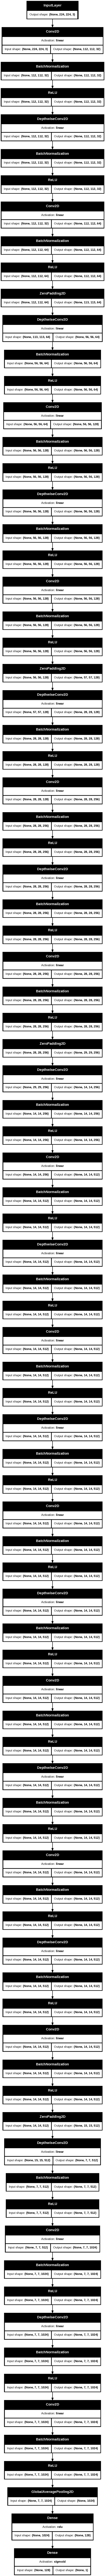

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
# Train the extra Layers only
history = model.fit(
    train_dataset,
    validation_data=dev_dataset,
    epochs=10,  # Adjust as needed
    batch_size=32
)


Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.9683 - loss: 0.0797 - val_accuracy: 0.9815 - val_loss: 0.0479
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9870 - loss: 0.0340 - val_accuracy: 0.9798 - val_loss: 0.0517
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - accuracy: 0.9907 - loss: 0.0266 - val_accuracy: 0.9794 - val_loss: 0.0638
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 44s 73ms/step - accuracy: 0.9927 - loss: 0.0217 - val_accuracy: 0.9824 - val_loss: 0.0522
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - accuracy: 0.9940 - loss: 0.0171 - val_accuracy: 0.9828 - val_loss: 0.0522
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.9950 - loss: 0.0153 - val_accuracy: 0.9819 - val_loss: 0.0610
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9947 - loss: 0.0140 - val_accuracy: 0.9828 - val_loss: 0.0648
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9954 - loss: 0.0117 - 

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on test data
y_true = np.concatenate([y.numpy() for _, y in test_dataset])
y_pred = model.predict(test_dataset)
y_pred = np.where(y_pred > 0.5, 1, 0).flatten()  # Convert probabilities to binary predictions


73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9897 - loss: 0.0461
Test Accuracy: 98.75%
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['Cat', 'Dog'])
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[1151    9]
 [  20 1146]]
Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.99      0.99      1160
         Dog       0.99      0.98      0.99      1166

    accuracy                           0.99      2326
   macro avg       0.99      0.99      0.99      2326
weighted avg       0.99      0.99      0.99      2326



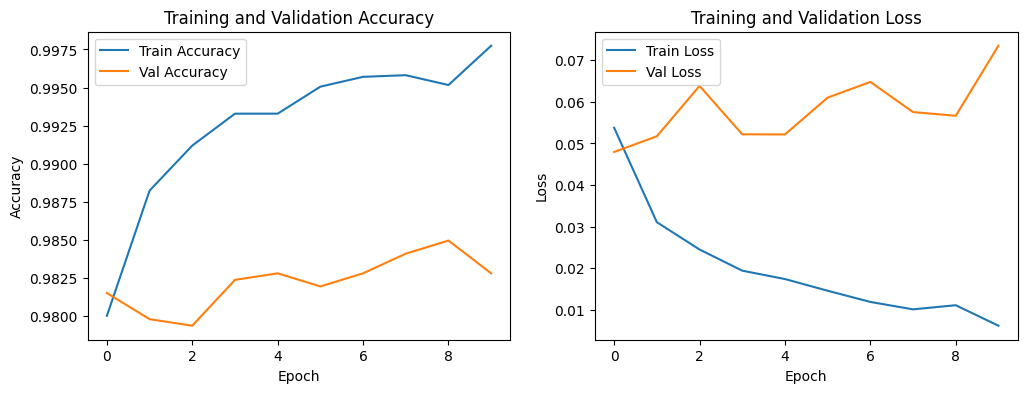

In [ ]:
# Plot training and validation curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Save the model in SavedModel format (protobuf files)
model_save_path = '/content/drive/My Drive/saved_models/cats_vs_dogs_protopath'
tf.saved_model.save(model, model_save_path)

Mounted at /content/drive


### Evaluate on our data

In [ ]:
from google.colab import files

# Upload images
uploaded = files.upload()

In [ ]:
import os
# Check uploaded files
uploaded_files = os.listdir()
print(uploaded_files)
print(os.getcwd())

In [ ]:
from logging import exception
import shutil
# Create the directories if they do not exist
our_data_dir = '/content/test_data'
os.makedirs(our_data_dir, exist_ok=True)
for i, file_name in enumerate(uploaded_files):
  if file_name.endswith('.jpg'):
    try:
      shutil.move(file_name, our_data_dir)
    except Exception as e:
      print(f"Error moving {file_name}: {e}")
print(os.listdir())
print(os.listdir(our_data_dir))

In [ ]:
import tensorflow as tf
# Normalize the image pixels to be from 0 to 1 (float32)
def normalize_img(image, label):
  return (tf.cast(image, tf.float32) / 255.0, label)
# Resize the image to 224x224
def resize(image, label):
  return (tf.image.resize(image, (224, 224)), label)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess images using the existing resize and normalize_img functions
def load_and_preprocess_image(file_path, target_size=(224, 224)):
    # Load the image
    img = image.load_img(file_path, target_size=target_size)

    # Convert image to numpy array and add batch dimension
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Convert to a TensorFlow tensor
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    # Apply resizing and normalization functions
    img_tensor = resize(img_tensor, None)[0]  # Resize
    img_tensor = normalize_img(img_tensor, None)[0]  # Normalize

    return img_tensor


image_arrays = []
for file_name in os.listdir(our_data_dir):
    print(file_name)
    if file_name.endswith('.jpg'):
      img_tensor = load_and_preprocess_image(our_data_dir + '/' + file_name)
      image_arrays.append(img_tensor)
for img in image_arrays:
  print(img.shape)

In [ ]:
import matplotlib.pyplot as plt

# Number of rows and columns for displaying images
num_rows = 2
num_cols = 5

# Create a figure with the specified size
plt.figure(figsize=(10, 6))

# Display images in a grid
for i, img in enumerate(image_arrays):
    # Create a subplot for each image
    plt.subplot(num_rows, num_cols, i + 1)  # (rows, cols, index)
    plt.imshow(img[0])  # Remove batch dimension for display
    plt.title(f"Image: {os.listdir(our_data_dir)[i]}")  # Display the file name as title
    plt.axis('off')  # Hide axis

# Adjust layout to avoid overlap and display the images
plt.tight_layout()
plt.show()

In [ ]:
# Labeling the data
Labels = [1, 0, 1, 0, 1, 0, 0, 1, 0, 1]
# Initialize a list to hold image-label pairs
image_label_pairs = []

# Iterate through the images and labels, pairing them together
for img_tensor, label in zip(image_arrays, Labels):
    image_label_pairs.append((img_tensor, label))

# Set up the figure with 2 rows and 5 columns (total 10 images)
fig, axes = plt.subplots(2, 5, figsize=(10, 6))  # 2 rows, 5 columns

# Iterate over the first 10 image-label pairs
for i, (img_tensor, label) in enumerate(image_label_pairs[:10]):
    row = i // 5  # Calculate the row index (0 or 1)
    col = i % 5   # Calculate the column index (0 to 4)

    # Plot each image on its respective subplot
    ax = axes[row, col]
    ax.imshow(img_tensor[0])  # Remove batch dimension for display
    ax.set_title("Cat" if label == 0 else "Dog")  # Display the label as title
    ax.axis('off')  # Hide axis

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:

# Function to predict and compare with actual labels
def predict_and_compare(model, image_label_pairs):
    predicted_labels = []  # Initialize an empty list to store predicted labels
    for i, (img_tensor, actual_label) in enumerate(image_label_pairs):
        # Predict the output (probabilities) for the image
        prediction = model.predict(img_tensor)

        # Convert probabilities to binary predictions (Cat: 0, Dog: 1)
        predicted_label = np.where(prediction > 0.5, 1, 0).flatten()[0]  # Convert and get a single value
        predicted_labels.append(predicted_label)  # Append the predicted label to the list
        # Print predicted vs actual label
        print(f"Image {i+1}:")
        print(f"  Actual label: {'Cat' if actual_label == 0 else 'Dog'}")
        print(f"  Predicted label: {'Cat' if predicted_label == 0 else 'Dog'}\n")
    return predicted_labels
# Call the function with your model and image-label pairs
predicted_labels = predict_and_compare(model, image_label_pairs)
print("Actual Labels:    ",Labels)
print("Predicted Labels: ",predicted_labels)
